## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, TensorDataset, Dataset
from torchvision.datasets import DatasetFolder

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.ColorJitter((0.875, 1.125), (0.5, 1.5), (0.5, 1.5), (-0.05, 0.05)),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Model

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.


## Training


In [4]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]


In [5]:
def get_pseudo_labels(dataset, model, threshold):
    # This functions generates pseudo-label of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    index = []
    label = []

    for i, batch in enumerate(tqdm(dataloader)):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                index.append(i * batch_size + j)
                label.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    model.train()
    return PseudoDataset(Subset(dataset, index), label)


In [6]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [7]:
def train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, train_loader, valid_loader, train_set, unlabeled_set):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.
    best_loss = 100.
    best_epoch = 0
    best_model = None
    acc_threshold = 0.70
    pseudo_threshold = 0.95
    ending_threshold = 50

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi and best_acc > acc_threshold:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, pseudo_threshold)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
            ending_threshold = 100

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Save the loss and accuracy for each epoch.
        history["train_loss"].append(train_loss)
        history["val_loss"].append(valid_loss)
        history["train_acc"].append(train_acc.cpu())
        history["val_acc"].append(valid_acc.cpu())

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") >= float(f"{best_acc:.5f}") and round(valid_loss, 5) < round(best_loss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{best_epoch + 1}_{best_acc}.pth")
            best_acc = valid_acc
            best_loss = valid_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        # Print the information.
        print(f"[Train | {epoch + 1:03d}/{n_epochs:03d}] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
        print(f"[Valid | {epoch + 1:03d}/{n_epochs:03d}][Best | {best_epoch + 1}] loss = {valid_loss:.5f}[{best_loss:.5f}], acc = {valid_acc:.5f}[{best_acc:.5f}]")

        if epoch - best_epoch >= ending_threshold:
            break

    # Return model and history for later use.
    return best_model, history


In [8]:
def concat_history(history1: dict, history2: dict):
    for key in history1.keys() & history2.keys():
        history1[key] = history1[key] + history2[key]


In [9]:
def plot_loss(history):
    plt.plot([*range(1, len(history["train_loss"]) + 1)], history["train_loss"])
    plt.plot([*range(1, len(history["val_loss"]) + 1)], history["val_loss"])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=["Train", "Validation"])


In [10]:
def plot_acc(history):
    plt.plot([*range(1, len(history["train_acc"]) + 1)], history["train_acc"])
    plt.plot([*range(1, len(history["val_acc"]) + 1)], history["val_acc"])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=["Train", "Validation"])


In [11]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = torchvision.models.efficientnet_v2_l(weights=None).to(device)
# model_path = "model/name/path.pth"
# model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 2000

# Whether to do semi-supervised learning.
do_semi = True

# Save history of accuracy and loss.
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}


In [12]:
bestd_model, train_history = train_model(model, n_epochs, do_semi, device, batch_size, criterion, optimizer, train_loader, valid_loader, train_set, unlabeled_set)
concat_history(history, train_history)


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 001/2000] loss = 5.58532, acc = 0.07673
[Valid | 001/2000][Best | 1] loss = 3.48240[3.48240], acc = 0.10119[0.10119]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 002/2000] loss = 2.63357, acc = 0.10805
[Valid | 002/2000][Best | 2] loss = 2.90509[2.90509], acc = 0.10417[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 003/2000] loss = 2.47423, acc = 0.09378
[Valid | 003/2000][Best | 2] loss = 2.43543[2.90509], acc = 0.09524[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 004/2000] loss = 2.44159, acc = 0.09625
[Valid | 004/2000][Best | 2] loss = 2.41034[2.90509], acc = 0.08036[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 005/2000] loss = 2.43583, acc = 0.08843
[Valid | 005/2000][Best | 2] loss = 2.38958[2.90509], acc = 0.10119[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 006/2000] loss = 2.42645, acc = 0.08767
[Valid | 006/2000][Best | 2] loss = 2.40698[2.90509], acc = 0.08482[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 007/2000] loss = 2.41726, acc = 0.09070
[Valid | 007/2000][Best | 2] loss = 2.40246[2.90509], acc = 0.09722[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 008/2000] loss = 2.42037, acc = 0.09040
[Valid | 008/2000][Best | 2] loss = 2.40217[2.90509], acc = 0.09921[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 009/2000] loss = 2.41716, acc = 0.09660
[Valid | 009/2000][Best | 2] loss = 2.39973[2.90509], acc = 0.09871[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 010/2000] loss = 2.41918, acc = 0.08328
[Valid | 010/2000][Best | 2] loss = 2.40413[2.90509], acc = 0.08978[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 011/2000] loss = 2.41691, acc = 0.09085
[Valid | 011/2000][Best | 2] loss = 2.39194[2.90509], acc = 0.10367[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 012/2000] loss = 2.40925, acc = 0.09721
[Valid | 012/2000][Best | 2] loss = 2.38601[2.90509], acc = 0.09077[0.10417]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 013/2000] loss = 2.41073, acc = 0.10089
[Valid | 013/2000][Best | 13] loss = 2.38585[2.38585], acc = 0.11706[0.11706]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 014/2000] loss = 2.41103, acc = 0.09418
[Valid | 014/2000][Best | 13] loss = 2.39013[2.38585], acc = 0.10069[0.11706]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 015/2000] loss = 2.40524, acc = 0.10447
[Valid | 015/2000][Best | 13] loss = 2.40105[2.38585], acc = 0.10863[0.11706]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 016/2000] loss = 2.40056, acc = 0.10255
[Valid | 016/2000][Best | 13] loss = 2.37395[2.38585], acc = 0.10119[0.11706]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 017/2000] loss = 2.39166, acc = 0.10639
[Valid | 017/2000][Best | 17] loss = 2.37450[2.37450], acc = 0.13095[0.13095]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 018/2000] loss = 2.40081, acc = 0.10931
[Valid | 018/2000][Best | 18] loss = 2.35811[2.35811], acc = 0.16071[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 019/2000] loss = 2.37977, acc = 0.11834
[Valid | 019/2000][Best | 18] loss = 2.33845[2.35811], acc = 0.13343[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 020/2000] loss = 2.37384, acc = 0.11420
[Valid | 020/2000][Best | 18] loss = 2.37463[2.35811], acc = 0.12302[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 021/2000] loss = 2.39335, acc = 0.10603
[Valid | 021/2000][Best | 18] loss = 2.38731[2.35811], acc = 0.10268[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 022/2000] loss = 2.38607, acc = 0.11526
[Valid | 022/2000][Best | 18] loss = 2.35043[2.35811], acc = 0.13244[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 023/2000] loss = 2.38044, acc = 0.11612
[Valid | 023/2000][Best | 18] loss = 2.35630[2.35811], acc = 0.13839[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 024/2000] loss = 2.37822, acc = 0.11950
[Valid | 024/2000][Best | 18] loss = 2.38982[2.35811], acc = 0.11954[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 025/2000] loss = 2.36969, acc = 0.12318
[Valid | 025/2000][Best | 18] loss = 2.31758[2.35811], acc = 0.13095[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 026/2000] loss = 2.36187, acc = 0.12757
[Valid | 026/2000][Best | 18] loss = 2.43638[2.35811], acc = 0.11905[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 027/2000] loss = 2.36940, acc = 0.11844
[Valid | 027/2000][Best | 18] loss = 2.30331[2.35811], acc = 0.14683[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 028/2000] loss = 2.36886, acc = 0.12843
[Valid | 028/2000][Best | 18] loss = 2.33278[2.35811], acc = 0.12847[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 029/2000] loss = 2.37513, acc = 0.11673
[Valid | 029/2000][Best | 18] loss = 2.30431[2.35811], acc = 0.14137[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 030/2000] loss = 2.37455, acc = 0.11188
[Valid | 030/2000][Best | 18] loss = 2.31096[2.35811], acc = 0.14038[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 031/2000] loss = 2.37229, acc = 0.12429
[Valid | 031/2000][Best | 18] loss = 2.35503[2.35811], acc = 0.14534[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 032/2000] loss = 2.36766, acc = 0.11733
[Valid | 032/2000][Best | 18] loss = 2.33697[2.35811], acc = 0.15129[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 033/2000] loss = 2.36252, acc = 0.12762
[Valid | 033/2000][Best | 18] loss = 2.32762[2.35811], acc = 0.16071[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 034/2000] loss = 2.35729, acc = 0.13842
[Valid | 034/2000][Best | 18] loss = 2.31632[2.35811], acc = 0.13988[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 035/2000] loss = 2.36158, acc = 0.11970
[Valid | 035/2000][Best | 18] loss = 2.32011[2.35811], acc = 0.13244[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 036/2000] loss = 2.35951, acc = 0.12561
[Valid | 036/2000][Best | 18] loss = 2.37801[2.35811], acc = 0.11806[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 037/2000] loss = 2.35781, acc = 0.13585
[Valid | 037/2000][Best | 18] loss = 2.32374[2.35811], acc = 0.13145[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 038/2000] loss = 2.35154, acc = 0.12611
[Valid | 038/2000][Best | 18] loss = 2.30158[2.35811], acc = 0.13641[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 039/2000] loss = 2.35538, acc = 0.12848
[Valid | 039/2000][Best | 18] loss = 2.30569[2.35811], acc = 0.13839[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 040/2000] loss = 2.34690, acc = 0.13221
[Valid | 040/2000][Best | 18] loss = 2.31496[2.35811], acc = 0.14484[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 041/2000] loss = 2.34199, acc = 0.13791
[Valid | 041/2000][Best | 18] loss = 2.31555[2.35811], acc = 0.14881[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 042/2000] loss = 2.32747, acc = 0.15073
[Valid | 042/2000][Best | 18] loss = 2.36963[2.35811], acc = 0.12153[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 043/2000] loss = 2.32624, acc = 0.13726
[Valid | 043/2000][Best | 18] loss = 2.35198[2.35811], acc = 0.12748[0.16071]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 044/2000] loss = 2.33432, acc = 0.13141
[Valid | 044/2000][Best | 44] loss = 2.24444[2.24444], acc = 0.16667[0.16667]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 045/2000] loss = 2.31680, acc = 0.14825
[Valid | 045/2000][Best | 44] loss = 2.28231[2.24444], acc = 0.14385[0.16667]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 046/2000] loss = 2.30300, acc = 0.14730
[Valid | 046/2000][Best | 44] loss = 2.24249[2.24444], acc = 0.15675[0.16667]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 047/2000] loss = 2.31401, acc = 0.13660
[Valid | 047/2000][Best | 44] loss = 2.28273[2.24444], acc = 0.15873[0.16667]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 048/2000] loss = 2.27585, acc = 0.15562
[Valid | 048/2000][Best | 48] loss = 2.19523[2.19523], acc = 0.19246[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 049/2000] loss = 2.29347, acc = 0.15118
[Valid | 049/2000][Best | 48] loss = 2.30090[2.19523], acc = 0.15675[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 050/2000] loss = 2.27806, acc = 0.16127
[Valid | 050/2000][Best | 48] loss = 2.27640[2.19523], acc = 0.14633[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 051/2000] loss = 2.28155, acc = 0.15527
[Valid | 051/2000][Best | 48] loss = 2.22245[2.19523], acc = 0.16270[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 052/2000] loss = 2.26429, acc = 0.16354
[Valid | 052/2000][Best | 48] loss = 2.23682[2.19523], acc = 0.14980[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 053/2000] loss = 2.28098, acc = 0.15522
[Valid | 053/2000][Best | 48] loss = 2.29233[2.19523], acc = 0.13591[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 054/2000] loss = 2.26270, acc = 0.15456
[Valid | 054/2000][Best | 48] loss = 2.22590[2.19523], acc = 0.15377[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 055/2000] loss = 2.25859, acc = 0.16561
[Valid | 055/2000][Best | 48] loss = 2.27620[2.19523], acc = 0.16518[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 056/2000] loss = 2.26518, acc = 0.16127
[Valid | 056/2000][Best | 48] loss = 2.23060[2.19523], acc = 0.14980[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 057/2000] loss = 2.25269, acc = 0.17055
[Valid | 057/2000][Best | 48] loss = 2.54874[2.19523], acc = 0.16419[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 058/2000] loss = 2.25556, acc = 0.16783
[Valid | 058/2000][Best | 48] loss = 2.20358[2.19523], acc = 0.15625[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 059/2000] loss = 2.24474, acc = 0.17721
[Valid | 059/2000][Best | 48] loss = 2.25149[2.19523], acc = 0.16617[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 060/2000] loss = 2.24418, acc = 0.16959
[Valid | 060/2000][Best | 48] loss = 2.16876[2.19523], acc = 0.16766[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 061/2000] loss = 2.23586, acc = 0.17166
[Valid | 061/2000][Best | 48] loss = 2.24997[2.19523], acc = 0.14633[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 062/2000] loss = 2.25923, acc = 0.16909
[Valid | 062/2000][Best | 48] loss = 2.20270[2.19523], acc = 0.15923[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 063/2000] loss = 2.23295, acc = 0.17781
[Valid | 063/2000][Best | 48] loss = 2.23047[2.19523], acc = 0.17361[0.19246]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 064/2000] loss = 2.23580, acc = 0.16566
[Valid | 064/2000][Best | 64] loss = 2.17966[2.17966], acc = 0.19444[0.19444]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 065/2000] loss = 2.22901, acc = 0.17418
[Valid | 065/2000][Best | 64] loss = 2.15081[2.17966], acc = 0.17609[0.19444]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 066/2000] loss = 2.23494, acc = 0.16621
[Valid | 066/2000][Best | 64] loss = 2.17421[2.17966], acc = 0.17014[0.19444]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 067/2000] loss = 2.22010, acc = 0.17217
[Valid | 067/2000][Best | 67] loss = 2.16416[2.16416], acc = 0.19544[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 068/2000] loss = 2.22927, acc = 0.16389
[Valid | 068/2000][Best | 67] loss = 2.19534[2.16416], acc = 0.17460[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 069/2000] loss = 2.22730, acc = 0.17131
[Valid | 069/2000][Best | 67] loss = 2.19543[2.16416], acc = 0.19097[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 070/2000] loss = 2.21192, acc = 0.17837
[Valid | 070/2000][Best | 67] loss = 2.21159[2.16416], acc = 0.16915[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 071/2000] loss = 2.21435, acc = 0.18079
[Valid | 071/2000][Best | 67] loss = 2.16542[2.16416], acc = 0.18353[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 072/2000] loss = 2.20867, acc = 0.19012
[Valid | 072/2000][Best | 67] loss = 2.17179[2.16416], acc = 0.19643[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 073/2000] loss = 2.20265, acc = 0.18972
[Valid | 073/2000][Best | 67] loss = 2.17346[2.16416], acc = 0.18800[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 074/2000] loss = 2.19286, acc = 0.17867
[Valid | 074/2000][Best | 67] loss = 2.16000[2.16416], acc = 0.18452[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 075/2000] loss = 2.20061, acc = 0.17358
[Valid | 075/2000][Best | 67] loss = 2.19550[2.16416], acc = 0.18204[0.19544]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 076/2000] loss = 2.20930, acc = 0.17459
[Valid | 076/2000][Best | 76] loss = 2.16240[2.16240], acc = 0.19742[0.19742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 077/2000] loss = 2.19877, acc = 0.17686
[Valid | 077/2000][Best | 76] loss = 2.18732[2.16240], acc = 0.15873[0.19742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 078/2000] loss = 2.19417, acc = 0.18992
[Valid | 078/2000][Best | 76] loss = 2.18333[2.16240], acc = 0.18601[0.19742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 079/2000] loss = 2.19693, acc = 0.17660
[Valid | 079/2000][Best | 76] loss = 2.14547[2.16240], acc = 0.19643[0.19742]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 080/2000] loss = 2.20010, acc = 0.18074
[Valid | 080/2000][Best | 80] loss = 2.15171[2.15171], acc = 0.20387[0.20387]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 081/2000] loss = 2.22088, acc = 0.18150
[Valid | 081/2000][Best | 80] loss = 2.13415[2.15171], acc = 0.19940[0.20387]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 082/2000] loss = 2.18983, acc = 0.19244
[Valid | 082/2000][Best | 82] loss = 2.10515[2.10515], acc = 0.21825[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 083/2000] loss = 2.19304, acc = 0.18992
[Valid | 083/2000][Best | 82] loss = 2.16290[2.10515], acc = 0.19444[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 084/2000] loss = 2.19605, acc = 0.17534
[Valid | 084/2000][Best | 82] loss = 2.08566[2.10515], acc = 0.21627[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 085/2000] loss = 2.17538, acc = 0.18291
[Valid | 085/2000][Best | 82] loss = 2.15758[2.10515], acc = 0.23016[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 086/2000] loss = 2.20114, acc = 0.18916
[Valid | 086/2000][Best | 82] loss = 2.11886[2.10515], acc = 0.21478[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 087/2000] loss = 2.19019, acc = 0.20162
[Valid | 087/2000][Best | 82] loss = 2.09696[2.10515], acc = 0.20387[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 088/2000] loss = 2.18454, acc = 0.19925
[Valid | 088/2000][Best | 82] loss = 2.15748[2.10515], acc = 0.20288[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 089/2000] loss = 2.17304, acc = 0.19350
[Valid | 089/2000][Best | 82] loss = 2.13155[2.10515], acc = 0.21429[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 090/2000] loss = 2.19974, acc = 0.19027
[Valid | 090/2000][Best | 82] loss = 2.10550[2.10515], acc = 0.22321[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 091/2000] loss = 2.16812, acc = 0.19845
[Valid | 091/2000][Best | 82] loss = 2.12822[2.10515], acc = 0.21230[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 092/2000] loss = 2.17900, acc = 0.20495
[Valid | 092/2000][Best | 82] loss = 2.13396[2.10515], acc = 0.22073[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 093/2000] loss = 2.16590, acc = 0.19976
[Valid | 093/2000][Best | 82] loss = 2.20185[2.10515], acc = 0.17560[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 094/2000] loss = 2.18419, acc = 0.20223
[Valid | 094/2000][Best | 82] loss = 2.10402[2.10515], acc = 0.20833[0.21825]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 095/2000] loss = 2.16973, acc = 0.21449
[Valid | 095/2000][Best | 95] loss = 2.06930[2.06930], acc = 0.23562[0.23562]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 096/2000] loss = 2.17481, acc = 0.20743
[Valid | 096/2000][Best | 95] loss = 2.08012[2.06930], acc = 0.25198[0.23562]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 097/2000] loss = 2.16142, acc = 0.20970
[Valid | 097/2000][Best | 97] loss = 2.05554[2.05554], acc = 0.23958[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 098/2000] loss = 2.16702, acc = 0.21121
[Valid | 098/2000][Best | 97] loss = 2.07611[2.05554], acc = 0.24802[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 099/2000] loss = 2.16430, acc = 0.21681
[Valid | 099/2000][Best | 97] loss = 2.07102[2.05554], acc = 0.22024[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 100/2000] loss = 2.16749, acc = 0.20722
[Valid | 100/2000][Best | 97] loss = 2.05691[2.05554], acc = 0.24157[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 101/2000] loss = 2.14375, acc = 0.20551
[Valid | 101/2000][Best | 97] loss = 2.08100[2.05554], acc = 0.22421[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 102/2000] loss = 2.15701, acc = 0.20616
[Valid | 102/2000][Best | 97] loss = 2.09480[2.05554], acc = 0.21776[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 103/2000] loss = 2.14407, acc = 0.21787
[Valid | 103/2000][Best | 97] loss = 2.10159[2.05554], acc = 0.23661[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 104/2000] loss = 2.16242, acc = 0.20243
[Valid | 104/2000][Best | 97] loss = 2.10285[2.05554], acc = 0.25942[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 105/2000] loss = 2.13911, acc = 0.23371
[Valid | 105/2000][Best | 97] loss = 2.06680[2.05554], acc = 0.23016[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 106/2000] loss = 2.12988, acc = 0.23330
[Valid | 106/2000][Best | 97] loss = 2.10566[2.05554], acc = 0.24058[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 107/2000] loss = 2.14253, acc = 0.22523
[Valid | 107/2000][Best | 97] loss = 2.05736[2.05554], acc = 0.26786[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 108/2000] loss = 2.14898, acc = 0.22912
[Valid | 108/2000][Best | 97] loss = 2.21877[2.05554], acc = 0.20486[0.23958]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 109/2000] loss = 2.13587, acc = 0.22286
[Valid | 109/2000][Best | 109] loss = 2.03788[2.03788], acc = 0.25992[0.25992]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 110/2000] loss = 2.13726, acc = 0.22861
[Valid | 110/2000][Best | 109] loss = 2.06546[2.03788], acc = 0.25000[0.25992]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 111/2000] loss = 2.12474, acc = 0.22316
[Valid | 111/2000][Best | 109] loss = 2.04434[2.03788], acc = 0.25992[0.25992]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 112/2000] loss = 2.10048, acc = 0.24556
[Valid | 112/2000][Best | 109] loss = 2.02499[2.03788], acc = 0.25942[0.25992]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 113/2000] loss = 2.12663, acc = 0.22972
[Valid | 113/2000][Best | 109] loss = 2.04459[2.03788], acc = 0.27034[0.25992]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 114/2000] loss = 2.11118, acc = 0.24097
[Valid | 114/2000][Best | 114] loss = 1.98532[1.98532], acc = 0.26587[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 115/2000] loss = 2.10429, acc = 0.23436
[Valid | 115/2000][Best | 114] loss = 2.10318[1.98532], acc = 0.24554[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 116/2000] loss = 2.09924, acc = 0.25071
[Valid | 116/2000][Best | 114] loss = 2.07621[1.98532], acc = 0.26042[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 117/2000] loss = 2.12348, acc = 0.23068
[Valid | 117/2000][Best | 114] loss = 2.03711[1.98532], acc = 0.26835[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 118/2000] loss = 2.10591, acc = 0.23537
[Valid | 118/2000][Best | 114] loss = 2.14003[1.98532], acc = 0.22817[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 119/2000] loss = 2.10682, acc = 0.23487
[Valid | 119/2000][Best | 114] loss = 2.04246[1.98532], acc = 0.28968[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 120/2000] loss = 2.09497, acc = 0.24894
[Valid | 120/2000][Best | 114] loss = 2.05992[1.98532], acc = 0.25347[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 121/2000] loss = 2.10230, acc = 0.24581
[Valid | 121/2000][Best | 114] loss = 2.14274[1.98532], acc = 0.23562[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 122/2000] loss = 2.11562, acc = 0.23340
[Valid | 122/2000][Best | 114] loss = 2.03223[1.98532], acc = 0.26240[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 123/2000] loss = 2.09405, acc = 0.24854
[Valid | 123/2000][Best | 114] loss = 2.08359[1.98532], acc = 0.26786[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 124/2000] loss = 2.08192, acc = 0.24828
[Valid | 124/2000][Best | 114] loss = 2.04533[1.98532], acc = 0.25595[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 125/2000] loss = 2.09746, acc = 0.24970
[Valid | 125/2000][Best | 114] loss = 2.01892[1.98532], acc = 0.25694[0.26587]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 126/2000] loss = 2.08523, acc = 0.25494
[Valid | 126/2000][Best | 126] loss = 1.96825[1.96825], acc = 0.27728[0.27728]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 127/2000] loss = 2.09617, acc = 0.25030
[Valid | 127/2000][Best | 126] loss = 2.01353[1.96825], acc = 0.27679[0.27728]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 128/2000] loss = 2.07415, acc = 0.26972
[Valid | 128/2000][Best | 128] loss = 1.95564[1.95564], acc = 0.29117[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 129/2000] loss = 2.06696, acc = 0.26271
[Valid | 129/2000][Best | 128] loss = 1.96578[1.95564], acc = 0.28968[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 130/2000] loss = 2.06847, acc = 0.26226
[Valid | 130/2000][Best | 128] loss = 2.09021[1.95564], acc = 0.25298[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 131/2000] loss = 2.06596, acc = 0.26836
[Valid | 131/2000][Best | 128] loss = 2.04579[1.95564], acc = 0.25099[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 132/2000] loss = 2.06594, acc = 0.26463
[Valid | 132/2000][Best | 128] loss = 2.00004[1.95564], acc = 0.28373[0.29117]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 133/2000] loss = 2.03679, acc = 0.28062
[Valid | 133/2000][Best | 133] loss = 1.94928[1.94928], acc = 0.30903[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 134/2000] loss = 2.05561, acc = 0.26831
[Valid | 134/2000][Best | 133] loss = 2.00936[1.94928], acc = 0.28323[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 135/2000] loss = 2.04545, acc = 0.27396
[Valid | 135/2000][Best | 133] loss = 1.95972[1.94928], acc = 0.29117[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 136/2000] loss = 2.06981, acc = 0.26907
[Valid | 136/2000][Best | 133] loss = 1.96358[1.94928], acc = 0.29514[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 137/2000] loss = 2.08489, acc = 0.25817
[Valid | 137/2000][Best | 133] loss = 1.98048[1.94928], acc = 0.27282[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 138/2000] loss = 2.03846, acc = 0.27305
[Valid | 138/2000][Best | 133] loss = 1.97727[1.94928], acc = 0.32143[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 139/2000] loss = 2.04298, acc = 0.28001
[Valid | 139/2000][Best | 133] loss = 1.93877[1.94928], acc = 0.28770[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 140/2000] loss = 2.06863, acc = 0.26892
[Valid | 140/2000][Best | 133] loss = 1.96140[1.94928], acc = 0.31399[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 141/2000] loss = 2.05057, acc = 0.26544
[Valid | 141/2000][Best | 133] loss = 1.91186[1.94928], acc = 0.30506[0.30903]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 142/2000] loss = 2.06129, acc = 0.27346
[Valid | 142/2000][Best | 142] loss = 1.90390[1.90390], acc = 0.32341[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 143/2000] loss = 2.04404, acc = 0.26105
[Valid | 143/2000][Best | 142] loss = 1.95083[1.90390], acc = 0.29415[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 144/2000] loss = 2.03509, acc = 0.28652
[Valid | 144/2000][Best | 142] loss = 1.93662[1.90390], acc = 0.32440[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 145/2000] loss = 2.02112, acc = 0.27971
[Valid | 145/2000][Best | 142] loss = 1.91916[1.90390], acc = 0.31151[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 146/2000] loss = 2.03013, acc = 0.27416
[Valid | 146/2000][Best | 142] loss = 2.00299[1.90390], acc = 0.28819[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 147/2000] loss = 2.03665, acc = 0.27941
[Valid | 147/2000][Best | 142] loss = 1.99548[1.90390], acc = 0.28423[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 148/2000] loss = 2.01116, acc = 0.28824
[Valid | 148/2000][Best | 142] loss = 1.96194[1.90390], acc = 0.28770[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 149/2000] loss = 2.02892, acc = 0.28602
[Valid | 149/2000][Best | 142] loss = 2.04669[1.90390], acc = 0.27083[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 150/2000] loss = 2.01847, acc = 0.29863
[Valid | 150/2000][Best | 142] loss = 1.98705[1.90390], acc = 0.29762[0.32341]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 151/2000] loss = 2.01413, acc = 0.29020
[Valid | 151/2000][Best | 151] loss = 1.85052[1.85052], acc = 0.33036[0.33036]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 152/2000] loss = 2.02248, acc = 0.29893
[Valid | 152/2000][Best | 151] loss = 1.93177[1.85052], acc = 0.29216[0.33036]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 153/2000] loss = 1.97741, acc = 0.30428
[Valid | 153/2000][Best | 151] loss = 1.90161[1.85052], acc = 0.30109[0.33036]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 154/2000] loss = 1.99521, acc = 0.29858
[Valid | 154/2000][Best | 151] loss = 1.86186[1.85052], acc = 0.32143[0.33036]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 155/2000] loss = 2.02657, acc = 0.28148
[Valid | 155/2000][Best | 151] loss = 1.94361[1.85052], acc = 0.31647[0.33036]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 156/2000] loss = 1.99554, acc = 0.30054
[Valid | 156/2000][Best | 156] loss = 1.83925[1.83925], acc = 0.36458[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 157/2000] loss = 1.99601, acc = 0.29479
[Valid | 157/2000][Best | 156] loss = 1.85477[1.83925], acc = 0.35020[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 158/2000] loss = 1.99119, acc = 0.30251
[Valid | 158/2000][Best | 156] loss = 1.87286[1.83925], acc = 0.33383[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 159/2000] loss = 1.99849, acc = 0.29938
[Valid | 159/2000][Best | 156] loss = 1.86098[1.83925], acc = 0.32639[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 160/2000] loss = 1.97892, acc = 0.30105
[Valid | 160/2000][Best | 156] loss = 1.88897[1.83925], acc = 0.32589[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 161/2000] loss = 1.98555, acc = 0.30070
[Valid | 161/2000][Best | 156] loss = 2.03611[1.83925], acc = 0.31300[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 162/2000] loss = 1.97533, acc = 0.30302
[Valid | 162/2000][Best | 156] loss = 1.91273[1.83925], acc = 0.32738[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 163/2000] loss = 1.97698, acc = 0.30710
[Valid | 163/2000][Best | 156] loss = 1.85215[1.83925], acc = 0.35764[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 164/2000] loss = 1.96252, acc = 0.31321
[Valid | 164/2000][Best | 156] loss = 1.94680[1.83925], acc = 0.29613[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 165/2000] loss = 1.95449, acc = 0.32072
[Valid | 165/2000][Best | 156] loss = 1.86850[1.83925], acc = 0.33185[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 166/2000] loss = 1.95774, acc = 0.32612
[Valid | 166/2000][Best | 156] loss = 1.88024[1.83925], acc = 0.32986[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 167/2000] loss = 1.95841, acc = 0.30993
[Valid | 167/2000][Best | 156] loss = 1.85857[1.83925], acc = 0.34970[0.36458]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 168/2000] loss = 1.95781, acc = 0.30846
[Valid | 168/2000][Best | 168] loss = 1.79641[1.79641], acc = 0.37252[0.37252]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 169/2000] loss = 1.96945, acc = 0.31134
[Valid | 169/2000][Best | 168] loss = 1.85114[1.79641], acc = 0.36359[0.37252]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 170/2000] loss = 1.95174, acc = 0.31200
[Valid | 170/2000][Best | 168] loss = 1.84275[1.79641], acc = 0.35863[0.37252]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 171/2000] loss = 1.96558, acc = 0.31073
[Valid | 171/2000][Best | 168] loss = 1.88342[1.79641], acc = 0.33929[0.37252]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 172/2000] loss = 1.94085, acc = 0.32965
[Valid | 172/2000][Best | 168] loss = 1.87089[1.79641], acc = 0.35417[0.37252]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 173/2000] loss = 1.95693, acc = 0.31881
[Valid | 173/2000][Best | 168] loss = 1.84107[1.79641], acc = 0.35962[0.37252]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 174/2000] loss = 1.92886, acc = 0.31714
[Valid | 174/2000][Best | 168] loss = 1.87043[1.79641], acc = 0.37550[0.37252]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 175/2000] loss = 1.93162, acc = 0.32723
[Valid | 175/2000][Best | 175] loss = 1.73822[1.73822], acc = 0.40377[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 176/2000] loss = 1.91383, acc = 0.33303
[Valid | 176/2000][Best | 175] loss = 1.77661[1.73822], acc = 0.37996[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 177/2000] loss = 1.91509, acc = 0.32819
[Valid | 177/2000][Best | 175] loss = 1.93316[1.73822], acc = 0.32540[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 178/2000] loss = 1.91737, acc = 0.32430
[Valid | 178/2000][Best | 175] loss = 1.92718[1.73822], acc = 0.30704[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 179/2000] loss = 1.93483, acc = 0.32622
[Valid | 179/2000][Best | 175] loss = 1.83557[1.73822], acc = 0.34821[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 180/2000] loss = 1.92633, acc = 0.33283
[Valid | 180/2000][Best | 175] loss = 1.83805[1.73822], acc = 0.37748[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 181/2000] loss = 1.91471, acc = 0.33318
[Valid | 181/2000][Best | 175] loss = 1.87414[1.73822], acc = 0.33780[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 182/2000] loss = 1.92019, acc = 0.32435
[Valid | 182/2000][Best | 175] loss = 1.79352[1.73822], acc = 0.38641[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 183/2000] loss = 1.92751, acc = 0.33424
[Valid | 183/2000][Best | 175] loss = 1.81880[1.73822], acc = 0.36855[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 184/2000] loss = 1.93527, acc = 0.32415
[Valid | 184/2000][Best | 175] loss = 1.74144[1.73822], acc = 0.37599[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 185/2000] loss = 1.89802, acc = 0.34045
[Valid | 185/2000][Best | 175] loss = 1.81152[1.73822], acc = 0.36855[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 186/2000] loss = 1.90377, acc = 0.33444
[Valid | 186/2000][Best | 175] loss = 1.74259[1.73822], acc = 0.39633[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 187/2000] loss = 1.89524, acc = 0.34453
[Valid | 187/2000][Best | 175] loss = 1.81027[1.73822], acc = 0.37798[0.40377]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 188/2000] loss = 1.91120, acc = 0.32930
[Valid | 188/2000][Best | 188] loss = 1.69210[1.69210], acc = 0.40873[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 189/2000] loss = 1.89096, acc = 0.35023
[Valid | 189/2000][Best | 188] loss = 1.91877[1.69210], acc = 0.37302[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 190/2000] loss = 1.90616, acc = 0.34489
[Valid | 190/2000][Best | 188] loss = 1.69927[1.69210], acc = 0.41518[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 191/2000] loss = 1.87705, acc = 0.35467
[Valid | 191/2000][Best | 188] loss = 1.72895[1.69210], acc = 0.40228[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 192/2000] loss = 1.86865, acc = 0.35043
[Valid | 192/2000][Best | 188] loss = 1.74968[1.69210], acc = 0.39980[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 193/2000] loss = 1.86268, acc = 0.35275
[Valid | 193/2000][Best | 188] loss = 1.70279[1.69210], acc = 0.41518[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 194/2000] loss = 1.86004, acc = 0.36612
[Valid | 194/2000][Best | 188] loss = 1.77493[1.69210], acc = 0.37748[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 195/2000] loss = 1.87433, acc = 0.34867
[Valid | 195/2000][Best | 188] loss = 1.71737[1.69210], acc = 0.42014[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 196/2000] loss = 1.85839, acc = 0.37672
[Valid | 196/2000][Best | 188] loss = 1.71732[1.69210], acc = 0.39187[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 197/2000] loss = 1.84415, acc = 0.35790
[Valid | 197/2000][Best | 188] loss = 1.76243[1.69210], acc = 0.39633[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 198/2000] loss = 1.85671, acc = 0.37409
[Valid | 198/2000][Best | 188] loss = 1.73376[1.69210], acc = 0.39187[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 199/2000] loss = 1.86812, acc = 0.35291
[Valid | 199/2000][Best | 188] loss = 1.69880[1.69210], acc = 0.40228[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 200/2000] loss = 1.86896, acc = 0.34776
[Valid | 200/2000][Best | 188] loss = 1.69538[1.69210], acc = 0.41815[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 201/2000] loss = 1.85994, acc = 0.36103
[Valid | 201/2000][Best | 188] loss = 1.79291[1.69210], acc = 0.40625[0.40873]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 202/2000] loss = 1.86986, acc = 0.35659
[Valid | 202/2000][Best | 202] loss = 1.68769[1.68769], acc = 0.41121[0.41121]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 203/2000] loss = 1.83648, acc = 0.36642
[Valid | 203/2000][Best | 202] loss = 1.70956[1.68769], acc = 0.43056[0.41121]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 204/2000] loss = 1.86882, acc = 0.36683
[Valid | 204/2000][Best | 202] loss = 1.79420[1.68769], acc = 0.39236[0.41121]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 205/2000] loss = 1.81672, acc = 0.37732
[Valid | 205/2000][Best | 202] loss = 1.78624[1.68769], acc = 0.38194[0.41121]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 206/2000] loss = 1.84375, acc = 0.36890
[Valid | 206/2000][Best | 202] loss = 1.75370[1.68769], acc = 0.40526[0.41121]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 207/2000] loss = 1.83276, acc = 0.37717
[Valid | 207/2000][Best | 207] loss = 1.62595[1.62595], acc = 0.43849[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 208/2000] loss = 1.81859, acc = 0.37969
[Valid | 208/2000][Best | 207] loss = 1.79293[1.62595], acc = 0.38046[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 209/2000] loss = 1.83356, acc = 0.36779
[Valid | 209/2000][Best | 207] loss = 1.69224[1.62595], acc = 0.40327[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 210/2000] loss = 1.79795, acc = 0.37480
[Valid | 210/2000][Best | 207] loss = 1.71203[1.62595], acc = 0.42312[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 211/2000] loss = 1.83648, acc = 0.37596
[Valid | 211/2000][Best | 207] loss = 1.66820[1.62595], acc = 0.43403[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 212/2000] loss = 1.80730, acc = 0.38186
[Valid | 212/2000][Best | 207] loss = 1.69911[1.62595], acc = 0.41915[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 213/2000] loss = 1.79646, acc = 0.38696
[Valid | 213/2000][Best | 207] loss = 1.71465[1.62595], acc = 0.41667[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 214/2000] loss = 1.78620, acc = 0.38327
[Valid | 214/2000][Best | 207] loss = 1.62857[1.62595], acc = 0.45437[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 215/2000] loss = 1.77720, acc = 0.38529
[Valid | 215/2000][Best | 207] loss = 1.67755[1.62595], acc = 0.45387[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 216/2000] loss = 1.81775, acc = 0.38282
[Valid | 216/2000][Best | 207] loss = 1.65943[1.62595], acc = 0.42857[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 217/2000] loss = 1.78391, acc = 0.39649
[Valid | 217/2000][Best | 207] loss = 1.84138[1.62595], acc = 0.34524[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 218/2000] loss = 1.81145, acc = 0.38252
[Valid | 218/2000][Best | 207] loss = 1.71973[1.62595], acc = 0.39236[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 219/2000] loss = 1.77814, acc = 0.39291
[Valid | 219/2000][Best | 207] loss = 1.65462[1.62595], acc = 0.44841[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 220/2000] loss = 1.78623, acc = 0.40123
[Valid | 220/2000][Best | 207] loss = 1.66501[1.62595], acc = 0.43056[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 221/2000] loss = 1.78214, acc = 0.39124
[Valid | 221/2000][Best | 207] loss = 1.71031[1.62595], acc = 0.40724[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 222/2000] loss = 1.78280, acc = 0.40320
[Valid | 222/2000][Best | 207] loss = 1.71897[1.62595], acc = 0.41071[0.43849]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 223/2000] loss = 1.78403, acc = 0.38635
[Valid | 223/2000][Best | 223] loss = 1.62255[1.62255], acc = 0.47520[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 224/2000] loss = 1.80736, acc = 0.38958
[Valid | 224/2000][Best | 223] loss = 1.66214[1.62255], acc = 0.44246[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 225/2000] loss = 1.78490, acc = 0.39624
[Valid | 225/2000][Best | 223] loss = 1.61268[1.62255], acc = 0.45982[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 226/2000] loss = 1.73163, acc = 0.40744
[Valid | 226/2000][Best | 223] loss = 1.57100[1.62255], acc = 0.45040[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 227/2000] loss = 1.74994, acc = 0.41248
[Valid | 227/2000][Best | 223] loss = 1.63044[1.62255], acc = 0.44990[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 228/2000] loss = 1.77777, acc = 0.39972
[Valid | 228/2000][Best | 223] loss = 1.60504[1.62255], acc = 0.45784[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 229/2000] loss = 1.77754, acc = 0.39185
[Valid | 229/2000][Best | 223] loss = 1.64170[1.62255], acc = 0.44990[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 230/2000] loss = 1.74947, acc = 0.41515
[Valid | 230/2000][Best | 223] loss = 1.65624[1.62255], acc = 0.45387[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 231/2000] loss = 1.73860, acc = 0.41102
[Valid | 231/2000][Best | 223] loss = 1.64391[1.62255], acc = 0.46875[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 232/2000] loss = 1.75991, acc = 0.40945
[Valid | 232/2000][Best | 223] loss = 1.67109[1.62255], acc = 0.44196[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 233/2000] loss = 1.76186, acc = 0.40542
[Valid | 233/2000][Best | 223] loss = 1.65899[1.62255], acc = 0.44147[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 234/2000] loss = 1.74032, acc = 0.41162
[Valid | 234/2000][Best | 223] loss = 1.62654[1.62255], acc = 0.45337[0.47520]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 235/2000] loss = 1.72971, acc = 0.42333
[Valid | 235/2000][Best | 235] loss = 1.60172[1.60172], acc = 0.48165[0.48165]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 236/2000] loss = 1.75405, acc = 0.40577
[Valid | 236/2000][Best | 235] loss = 1.62563[1.60172], acc = 0.43601[0.48165]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 237/2000] loss = 1.73056, acc = 0.41223
[Valid | 237/2000][Best | 235] loss = 1.65241[1.60172], acc = 0.44246[0.48165]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 238/2000] loss = 1.71124, acc = 0.42277
[Valid | 238/2000][Best | 238] loss = 1.52881[1.52881], acc = 0.50347[0.50347]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 239/2000] loss = 1.71351, acc = 0.42408
[Valid | 239/2000][Best | 238] loss = 1.59458[1.52881], acc = 0.45883[0.50347]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 240/2000] loss = 1.71034, acc = 0.41747
[Valid | 240/2000][Best | 238] loss = 1.69724[1.52881], acc = 0.45288[0.50347]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 241/2000] loss = 1.72622, acc = 0.41167
[Valid | 241/2000][Best | 238] loss = 1.64707[1.52881], acc = 0.44990[0.50347]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 242/2000] loss = 1.71659, acc = 0.42469
[Valid | 242/2000][Best | 238] loss = 1.50772[1.52881], acc = 0.49256[0.50347]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 243/2000] loss = 1.71951, acc = 0.42020
[Valid | 243/2000][Best | 238] loss = 1.58964[1.52881], acc = 0.48462[0.50347]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 244/2000] loss = 1.71714, acc = 0.41959
[Valid | 244/2000][Best | 238] loss = 1.58828[1.52881], acc = 0.46280[0.50347]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 245/2000] loss = 1.73719, acc = 0.41939
[Valid | 245/2000][Best | 245] loss = 1.48508[1.48508], acc = 0.51984[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 246/2000] loss = 1.72446, acc = 0.42116
[Valid | 246/2000][Best | 245] loss = 1.47508[1.48508], acc = 0.49653[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 247/2000] loss = 1.73411, acc = 0.41697
[Valid | 247/2000][Best | 245] loss = 1.59610[1.48508], acc = 0.47966[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 248/2000] loss = 1.71068, acc = 0.42832
[Valid | 248/2000][Best | 245] loss = 1.53141[1.48508], acc = 0.49901[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 249/2000] loss = 1.69718, acc = 0.42080
[Valid | 249/2000][Best | 245] loss = 1.56313[1.48508], acc = 0.48611[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 250/2000] loss = 1.68085, acc = 0.42988
[Valid | 250/2000][Best | 245] loss = 1.51985[1.48508], acc = 0.49802[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 251/2000] loss = 1.70377, acc = 0.41727
[Valid | 251/2000][Best | 245] loss = 1.63973[1.48508], acc = 0.43204[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 252/2000] loss = 1.68574, acc = 0.43654
[Valid | 252/2000][Best | 245] loss = 1.61139[1.48508], acc = 0.45238[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 253/2000] loss = 1.67612, acc = 0.41652
[Valid | 253/2000][Best | 245] loss = 1.48140[1.48508], acc = 0.50794[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 254/2000] loss = 1.64533, acc = 0.43689
[Valid | 254/2000][Best | 245] loss = 1.55450[1.48508], acc = 0.46974[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 255/2000] loss = 1.65245, acc = 0.44537
[Valid | 255/2000][Best | 245] loss = 1.56323[1.48508], acc = 0.48611[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 256/2000] loss = 1.68671, acc = 0.43094
[Valid | 256/2000][Best | 245] loss = 1.61547[1.48508], acc = 0.46478[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 257/2000] loss = 1.67191, acc = 0.44481
[Valid | 257/2000][Best | 245] loss = 1.50720[1.48508], acc = 0.49058[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 258/2000] loss = 1.67316, acc = 0.43357
[Valid | 258/2000][Best | 245] loss = 1.53056[1.48508], acc = 0.48760[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 259/2000] loss = 1.66664, acc = 0.44088
[Valid | 259/2000][Best | 245] loss = 1.46853[1.48508], acc = 0.50942[0.51984]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 260/2000] loss = 1.62687, acc = 0.44875
[Valid | 260/2000][Best | 260] loss = 1.48415[1.48415], acc = 0.52381[0.52381]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 261/2000] loss = 1.66208, acc = 0.44381
[Valid | 261/2000][Best | 260] loss = 1.45755[1.48415], acc = 0.51389[0.52381]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 262/2000] loss = 1.65242, acc = 0.44476
[Valid | 262/2000][Best | 260] loss = 1.53043[1.48415], acc = 0.48165[0.52381]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 263/2000] loss = 1.61822, acc = 0.46323
[Valid | 263/2000][Best | 260] loss = 1.51488[1.48415], acc = 0.50645[0.52381]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 264/2000] loss = 1.63844, acc = 0.45536
[Valid | 264/2000][Best | 260] loss = 1.47360[1.48415], acc = 0.50794[0.52381]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 265/2000] loss = 1.61516, acc = 0.45082
[Valid | 265/2000][Best | 260] loss = 1.57734[1.48415], acc = 0.47173[0.52381]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 266/2000] loss = 1.62614, acc = 0.45803
[Valid | 266/2000][Best | 260] loss = 1.46627[1.48415], acc = 0.51042[0.52381]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 267/2000] loss = 1.61733, acc = 0.45389
[Valid | 267/2000][Best | 260] loss = 1.44789[1.48415], acc = 0.51637[0.52381]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 268/2000] loss = 1.62484, acc = 0.45384
[Valid | 268/2000][Best | 268] loss = 1.43184[1.43184], acc = 0.53323[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 269/2000] loss = 1.62857, acc = 0.45874
[Valid | 269/2000][Best | 268] loss = 1.42512[1.43184], acc = 0.53323[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 270/2000] loss = 1.60298, acc = 0.46464
[Valid | 270/2000][Best | 268] loss = 1.46059[1.43184], acc = 0.52133[0.53323]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 271/2000] loss = 1.59855, acc = 0.46645
[Valid | 271/2000][Best | 271] loss = 1.40593[1.40593], acc = 0.55804[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 272/2000] loss = 1.64260, acc = 0.45102
[Valid | 272/2000][Best | 271] loss = 1.53589[1.40593], acc = 0.48562[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 273/2000] loss = 1.64685, acc = 0.44552
[Valid | 273/2000][Best | 271] loss = 1.45770[1.40593], acc = 0.52183[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 274/2000] loss = 1.59847, acc = 0.45536
[Valid | 274/2000][Best | 271] loss = 1.49461[1.40593], acc = 0.49157[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 275/2000] loss = 1.58964, acc = 0.46756
[Valid | 275/2000][Best | 271] loss = 1.39250[1.40593], acc = 0.55804[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 276/2000] loss = 1.61522, acc = 0.45021
[Valid | 276/2000][Best | 271] loss = 1.57307[1.40593], acc = 0.46776[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 277/2000] loss = 1.61796, acc = 0.46232
[Valid | 277/2000][Best | 271] loss = 1.42252[1.40593], acc = 0.51587[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 278/2000] loss = 1.60067, acc = 0.46792
[Valid | 278/2000][Best | 271] loss = 1.45022[1.40593], acc = 0.50595[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 279/2000] loss = 1.58220, acc = 0.46852
[Valid | 279/2000][Best | 271] loss = 1.41108[1.40593], acc = 0.54216[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 280/2000] loss = 1.60459, acc = 0.46867
[Valid | 280/2000][Best | 271] loss = 1.46088[1.40593], acc = 0.52976[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 281/2000] loss = 1.56044, acc = 0.47533
[Valid | 281/2000][Best | 271] loss = 1.42568[1.40593], acc = 0.52778[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 282/2000] loss = 1.57919, acc = 0.47675
[Valid | 282/2000][Best | 271] loss = 1.46334[1.40593], acc = 0.51637[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 283/2000] loss = 1.58799, acc = 0.46600
[Valid | 283/2000][Best | 271] loss = 1.48190[1.40593], acc = 0.52679[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 284/2000] loss = 1.56110, acc = 0.47377
[Valid | 284/2000][Best | 271] loss = 1.39492[1.40593], acc = 0.53968[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 285/2000] loss = 1.57641, acc = 0.46832
[Valid | 285/2000][Best | 271] loss = 1.46870[1.40593], acc = 0.50298[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 286/2000] loss = 1.54875, acc = 0.47392
[Valid | 286/2000][Best | 271] loss = 1.41325[1.40593], acc = 0.52530[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 287/2000] loss = 1.55834, acc = 0.47997
[Valid | 287/2000][Best | 271] loss = 1.40903[1.40593], acc = 0.53571[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 288/2000] loss = 1.58263, acc = 0.47574
[Valid | 288/2000][Best | 271] loss = 1.38709[1.40593], acc = 0.55655[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 289/2000] loss = 1.59200, acc = 0.47513
[Valid | 289/2000][Best | 271] loss = 1.39447[1.40593], acc = 0.54018[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 290/2000] loss = 1.58789, acc = 0.47624
[Valid | 290/2000][Best | 271] loss = 1.38261[1.40593], acc = 0.54514[0.55804]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 291/2000] loss = 1.55627, acc = 0.47705
[Valid | 291/2000][Best | 291] loss = 1.36623[1.36623], acc = 0.56200[0.56200]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 292/2000] loss = 1.58314, acc = 0.46751
[Valid | 292/2000][Best | 291] loss = 1.45133[1.36623], acc = 0.53125[0.56200]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 293/2000] loss = 1.55356, acc = 0.48134
[Valid | 293/2000][Best | 293] loss = 1.36097[1.36097], acc = 0.56300[0.56300]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 294/2000] loss = 1.54109, acc = 0.47922
[Valid | 294/2000][Best | 293] loss = 1.36740[1.36097], acc = 0.55159[0.56300]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 295/2000] loss = 1.54382, acc = 0.48467
[Valid | 295/2000][Best | 293] loss = 1.32032[1.36097], acc = 0.56002[0.56300]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 296/2000] loss = 1.57879, acc = 0.47064
[Valid | 296/2000][Best | 293] loss = 1.45384[1.36097], acc = 0.51885[0.56300]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 297/2000] loss = 1.54437, acc = 0.48915
[Valid | 297/2000][Best | 293] loss = 1.40978[1.36097], acc = 0.55109[0.56300]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 298/2000] loss = 1.58062, acc = 0.47538
[Valid | 298/2000][Best | 293] loss = 1.47940[1.36097], acc = 0.51984[0.56300]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 299/2000] loss = 1.51497, acc = 0.50525
[Valid | 299/2000][Best | 299] loss = 1.32942[1.32942], acc = 0.56498[0.56498]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 300/2000] loss = 1.51585, acc = 0.49733
[Valid | 300/2000][Best | 299] loss = 1.44382[1.32942], acc = 0.52629[0.56498]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 301/2000] loss = 1.54256, acc = 0.48169
[Valid | 301/2000][Best | 299] loss = 1.37752[1.32942], acc = 0.55605[0.56498]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 302/2000] loss = 1.52366, acc = 0.49092
[Valid | 302/2000][Best | 299] loss = 1.40171[1.32942], acc = 0.54514[0.56498]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 303/2000] loss = 1.50418, acc = 0.50535
[Valid | 303/2000][Best | 299] loss = 1.39310[1.32942], acc = 0.55556[0.56498]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 304/2000] loss = 1.55567, acc = 0.48729
[Valid | 304/2000][Best | 299] loss = 1.33965[1.32942], acc = 0.55060[0.56498]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 305/2000] loss = 1.51975, acc = 0.48376
[Valid | 305/2000][Best | 299] loss = 1.41405[1.32942], acc = 0.53026[0.56498]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 306/2000] loss = 1.52882, acc = 0.49642
[Valid | 306/2000][Best | 299] loss = 1.32274[1.32942], acc = 0.56052[0.56498]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 307/2000] loss = 1.53642, acc = 0.49773
[Valid | 307/2000][Best | 307] loss = 1.26416[1.26416], acc = 0.58234[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 308/2000] loss = 1.53552, acc = 0.48088
[Valid | 308/2000][Best | 307] loss = 1.41250[1.26416], acc = 0.53175[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 309/2000] loss = 1.50769, acc = 0.49793
[Valid | 309/2000][Best | 307] loss = 1.27882[1.26416], acc = 0.59028[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 310/2000] loss = 1.52561, acc = 0.50025
[Valid | 310/2000][Best | 307] loss = 1.39222[1.26416], acc = 0.52679[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 311/2000] loss = 1.52377, acc = 0.49057
[Valid | 311/2000][Best | 307] loss = 1.28569[1.26416], acc = 0.59524[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 312/2000] loss = 1.49593, acc = 0.49117
[Valid | 312/2000][Best | 307] loss = 1.31864[1.26416], acc = 0.55010[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 313/2000] loss = 1.50953, acc = 0.49934
[Valid | 313/2000][Best | 307] loss = 1.29864[1.26416], acc = 0.56101[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 314/2000] loss = 1.48074, acc = 0.50121
[Valid | 314/2000][Best | 307] loss = 1.29147[1.26416], acc = 0.59077[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 315/2000] loss = 1.50316, acc = 0.50217
[Valid | 315/2000][Best | 307] loss = 1.26923[1.26416], acc = 0.57986[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 316/2000] loss = 1.50625, acc = 0.50651
[Valid | 316/2000][Best | 307] loss = 1.31534[1.26416], acc = 0.57093[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 317/2000] loss = 1.50979, acc = 0.49037
[Valid | 317/2000][Best | 307] loss = 1.38544[1.26416], acc = 0.55109[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 318/2000] loss = 1.47753, acc = 0.50262
[Valid | 318/2000][Best | 307] loss = 1.32125[1.26416], acc = 0.57589[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 319/2000] loss = 1.48088, acc = 0.50676
[Valid | 319/2000][Best | 307] loss = 1.31446[1.26416], acc = 0.55853[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 320/2000] loss = 1.50435, acc = 0.49945
[Valid | 320/2000][Best | 307] loss = 1.34636[1.26416], acc = 0.56101[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 321/2000] loss = 1.47715, acc = 0.50938
[Valid | 321/2000][Best | 307] loss = 1.38731[1.26416], acc = 0.55456[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 322/2000] loss = 1.49336, acc = 0.51307
[Valid | 322/2000][Best | 307] loss = 1.31204[1.26416], acc = 0.56944[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 323/2000] loss = 1.48585, acc = 0.49884
[Valid | 323/2000][Best | 307] loss = 1.35478[1.26416], acc = 0.54365[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 324/2000] loss = 1.48714, acc = 0.50893
[Valid | 324/2000][Best | 307] loss = 1.42148[1.26416], acc = 0.53026[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 325/2000] loss = 1.44934, acc = 0.51266
[Valid | 325/2000][Best | 307] loss = 1.47220[1.26416], acc = 0.53819[0.58234]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 326/2000] loss = 1.48165, acc = 0.50827
[Valid | 326/2000][Best | 326] loss = 1.24577[1.24577], acc = 0.59722[0.59722]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 327/2000] loss = 1.46456, acc = 0.51836
[Valid | 327/2000][Best | 326] loss = 1.28245[1.24577], acc = 0.58135[0.59722]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 328/2000] loss = 1.46919, acc = 0.51317
[Valid | 328/2000][Best | 328] loss = 1.21597[1.21597], acc = 0.60069[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 329/2000] loss = 1.49374, acc = 0.51856
[Valid | 329/2000][Best | 328] loss = 1.23023[1.21597], acc = 0.61161[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 330/2000] loss = 1.50546, acc = 0.49117
[Valid | 330/2000][Best | 328] loss = 1.28485[1.21597], acc = 0.58284[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 331/2000] loss = 1.49343, acc = 0.50585
[Valid | 331/2000][Best | 328] loss = 1.28931[1.21597], acc = 0.57837[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 332/2000] loss = 1.44319, acc = 0.51130
[Valid | 332/2000][Best | 328] loss = 1.31092[1.21597], acc = 0.57937[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 333/2000] loss = 1.48017, acc = 0.50388
[Valid | 333/2000][Best | 328] loss = 1.29660[1.21597], acc = 0.59474[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 334/2000] loss = 1.46012, acc = 0.51786
[Valid | 334/2000][Best | 328] loss = 1.30888[1.21597], acc = 0.57540[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 335/2000] loss = 1.45597, acc = 0.50777
[Valid | 335/2000][Best | 328] loss = 1.21609[1.21597], acc = 0.59276[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 336/2000] loss = 1.46136, acc = 0.51599
[Valid | 336/2000][Best | 328] loss = 1.27547[1.21597], acc = 0.59573[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 337/2000] loss = 1.42434, acc = 0.53793
[Valid | 337/2000][Best | 328] loss = 1.26780[1.21597], acc = 0.60417[0.60069]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 338/2000] loss = 1.45265, acc = 0.51927
[Valid | 338/2000][Best | 338] loss = 1.15787[1.15787], acc = 0.62302[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 339/2000] loss = 1.44043, acc = 0.53218
[Valid | 339/2000][Best | 338] loss = 1.23818[1.15787], acc = 0.58383[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 340/2000] loss = 1.45733, acc = 0.51488
[Valid | 340/2000][Best | 338] loss = 1.20457[1.15787], acc = 0.61210[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 341/2000] loss = 1.43001, acc = 0.52810
[Valid | 341/2000][Best | 338] loss = 1.20226[1.15787], acc = 0.59375[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 342/2000] loss = 1.43629, acc = 0.52462
[Valid | 342/2000][Best | 338] loss = 1.22554[1.15787], acc = 0.59375[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 343/2000] loss = 1.44151, acc = 0.51836
[Valid | 343/2000][Best | 338] loss = 1.33774[1.15787], acc = 0.56597[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 344/2000] loss = 1.40900, acc = 0.53935
[Valid | 344/2000][Best | 338] loss = 1.29634[1.15787], acc = 0.58333[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 345/2000] loss = 1.43788, acc = 0.53329
[Valid | 345/2000][Best | 338] loss = 1.27000[1.15787], acc = 0.58532[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 346/2000] loss = 1.45049, acc = 0.51236
[Valid | 346/2000][Best | 338] loss = 1.24800[1.15787], acc = 0.59077[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 347/2000] loss = 1.41485, acc = 0.53173
[Valid | 347/2000][Best | 338] loss = 1.24687[1.15787], acc = 0.58780[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 348/2000] loss = 1.43438, acc = 0.52033
[Valid | 348/2000][Best | 338] loss = 1.27032[1.15787], acc = 0.57788[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 349/2000] loss = 1.40856, acc = 0.51216
[Valid | 349/2000][Best | 338] loss = 1.29531[1.15787], acc = 0.56448[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 350/2000] loss = 1.45696, acc = 0.51256
[Valid | 350/2000][Best | 338] loss = 1.34004[1.15787], acc = 0.55506[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 351/2000] loss = 1.41602, acc = 0.52991
[Valid | 351/2000][Best | 338] loss = 1.23134[1.15787], acc = 0.59127[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 352/2000] loss = 1.42697, acc = 0.51695
[Valid | 352/2000][Best | 338] loss = 1.24572[1.15787], acc = 0.57887[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 353/2000] loss = 1.42436, acc = 0.52063
[Valid | 353/2000][Best | 338] loss = 1.29454[1.15787], acc = 0.57093[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 354/2000] loss = 1.44939, acc = 0.51831
[Valid | 354/2000][Best | 338] loss = 1.29806[1.15787], acc = 0.58185[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 355/2000] loss = 1.38720, acc = 0.55160
[Valid | 355/2000][Best | 338] loss = 1.14002[1.15787], acc = 0.61855[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 356/2000] loss = 1.41549, acc = 0.53536
[Valid | 356/2000][Best | 338] loss = 1.28556[1.15787], acc = 0.57192[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 357/2000] loss = 1.41061, acc = 0.52951
[Valid | 357/2000][Best | 338] loss = 1.27795[1.15787], acc = 0.59276[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 358/2000] loss = 1.42835, acc = 0.52663
[Valid | 358/2000][Best | 338] loss = 1.26439[1.15787], acc = 0.58929[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 359/2000] loss = 1.41106, acc = 0.52946
[Valid | 359/2000][Best | 338] loss = 1.23885[1.15787], acc = 0.60615[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 360/2000] loss = 1.43287, acc = 0.51952
[Valid | 360/2000][Best | 338] loss = 1.35308[1.15787], acc = 0.56548[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 361/2000] loss = 1.37961, acc = 0.54056
[Valid | 361/2000][Best | 338] loss = 1.19070[1.15787], acc = 0.58929[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 362/2000] loss = 1.40553, acc = 0.53233
[Valid | 362/2000][Best | 338] loss = 1.20675[1.15787], acc = 0.58383[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 363/2000] loss = 1.38414, acc = 0.53440
[Valid | 363/2000][Best | 338] loss = 1.23801[1.15787], acc = 0.58879[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 364/2000] loss = 1.40740, acc = 0.52749
[Valid | 364/2000][Best | 338] loss = 1.19328[1.15787], acc = 0.60516[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 365/2000] loss = 1.36104, acc = 0.54999
[Valid | 365/2000][Best | 338] loss = 1.24203[1.15787], acc = 0.60169[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 366/2000] loss = 1.37234, acc = 0.55589
[Valid | 366/2000][Best | 338] loss = 1.26821[1.15787], acc = 0.58085[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 367/2000] loss = 1.37105, acc = 0.53909
[Valid | 367/2000][Best | 338] loss = 1.24963[1.15787], acc = 0.57986[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 368/2000] loss = 1.37487, acc = 0.54389
[Valid | 368/2000][Best | 338] loss = 1.25132[1.15787], acc = 0.57044[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 369/2000] loss = 1.35033, acc = 0.54631
[Valid | 369/2000][Best | 338] loss = 1.26630[1.15787], acc = 0.58135[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 370/2000] loss = 1.38321, acc = 0.53859
[Valid | 370/2000][Best | 338] loss = 1.29668[1.15787], acc = 0.56944[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 371/2000] loss = 1.38759, acc = 0.53632
[Valid | 371/2000][Best | 338] loss = 1.25492[1.15787], acc = 0.59524[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 372/2000] loss = 1.33785, acc = 0.54843
[Valid | 372/2000][Best | 338] loss = 1.17145[1.15787], acc = 0.61458[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 373/2000] loss = 1.32180, acc = 0.55882
[Valid | 373/2000][Best | 338] loss = 1.17544[1.15787], acc = 0.61161[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 374/2000] loss = 1.33086, acc = 0.56543
[Valid | 374/2000][Best | 338] loss = 1.18222[1.15787], acc = 0.60417[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 375/2000] loss = 1.36220, acc = 0.55090
[Valid | 375/2000][Best | 338] loss = 1.26313[1.15787], acc = 0.58929[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 376/2000] loss = 1.34134, acc = 0.54722
[Valid | 376/2000][Best | 338] loss = 1.26022[1.15787], acc = 0.60218[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 377/2000] loss = 1.36710, acc = 0.54762
[Valid | 377/2000][Best | 338] loss = 1.17358[1.15787], acc = 0.61210[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 378/2000] loss = 1.37736, acc = 0.54792
[Valid | 378/2000][Best | 338] loss = 1.25750[1.15787], acc = 0.59970[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 379/2000] loss = 1.34222, acc = 0.54853
[Valid | 379/2000][Best | 338] loss = 1.18959[1.15787], acc = 0.61458[0.62302]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 380/2000] loss = 1.33684, acc = 0.55640
[Valid | 380/2000][Best | 380] loss = 1.14926[1.14926], acc = 0.62946[0.62946]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 381/2000] loss = 1.31060, acc = 0.56543
[Valid | 381/2000][Best | 380] loss = 1.12538[1.14926], acc = 0.62450[0.62946]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 382/2000] loss = 1.37702, acc = 0.54651
[Valid | 382/2000][Best | 380] loss = 1.19588[1.14926], acc = 0.61409[0.62946]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 383/2000] loss = 1.33382, acc = 0.55746
[Valid | 383/2000][Best | 383] loss = 1.11300[1.11300], acc = 0.63492[0.63492]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 384/2000] loss = 1.35359, acc = 0.55357
[Valid | 384/2000][Best | 383] loss = 1.17363[1.11300], acc = 0.61260[0.63492]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 385/2000] loss = 1.35792, acc = 0.53990
[Valid | 385/2000][Best | 383] loss = 1.14499[1.11300], acc = 0.62302[0.63492]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 386/2000] loss = 1.33526, acc = 0.55453
[Valid | 386/2000][Best | 383] loss = 1.15898[1.11300], acc = 0.62153[0.63492]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 387/2000] loss = 1.36101, acc = 0.54737
[Valid | 387/2000][Best | 383] loss = 1.15160[1.11300], acc = 0.61806[0.63492]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 388/2000] loss = 1.36610, acc = 0.54898
[Valid | 388/2000][Best | 388] loss = 1.09747[1.09747], acc = 0.64931[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 389/2000] loss = 1.33083, acc = 0.55130
[Valid | 389/2000][Best | 388] loss = 1.10542[1.09747], acc = 0.63393[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 390/2000] loss = 1.33970, acc = 0.55423
[Valid | 390/2000][Best | 388] loss = 1.16778[1.09747], acc = 0.61905[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 391/2000] loss = 1.36376, acc = 0.54424
[Valid | 391/2000][Best | 388] loss = 1.09984[1.09747], acc = 0.63145[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 392/2000] loss = 1.34259, acc = 0.56447
[Valid | 392/2000][Best | 388] loss = 1.18385[1.09747], acc = 0.61111[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 393/2000] loss = 1.29957, acc = 0.57839
[Valid | 393/2000][Best | 388] loss = 1.12390[1.09747], acc = 0.61409[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 394/2000] loss = 1.31741, acc = 0.56411
[Valid | 394/2000][Best | 388] loss = 1.19673[1.09747], acc = 0.60863[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 395/2000] loss = 1.33980, acc = 0.55448
[Valid | 395/2000][Best | 388] loss = 1.32916[1.09747], acc = 0.56399[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 396/2000] loss = 1.27580, acc = 0.57173
[Valid | 396/2000][Best | 388] loss = 1.13054[1.09747], acc = 0.63442[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 397/2000] loss = 1.33817, acc = 0.56084
[Valid | 397/2000][Best | 388] loss = 1.12141[1.09747], acc = 0.64435[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 398/2000] loss = 1.33975, acc = 0.55428
[Valid | 398/2000][Best | 388] loss = 1.12175[1.09747], acc = 0.61806[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 399/2000] loss = 1.31577, acc = 0.55433
[Valid | 399/2000][Best | 388] loss = 1.19139[1.09747], acc = 0.61954[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 400/2000] loss = 1.33505, acc = 0.56013
[Valid | 400/2000][Best | 388] loss = 1.12999[1.09747], acc = 0.62550[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 401/2000] loss = 1.31568, acc = 0.55468
[Valid | 401/2000][Best | 388] loss = 1.15277[1.09747], acc = 0.63244[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 402/2000] loss = 1.29771, acc = 0.56532
[Valid | 402/2000][Best | 388] loss = 1.14087[1.09747], acc = 0.62054[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 403/2000] loss = 1.28700, acc = 0.56840
[Valid | 403/2000][Best | 388] loss = 1.13000[1.09747], acc = 0.62996[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 404/2000] loss = 1.30445, acc = 0.57319
[Valid | 404/2000][Best | 388] loss = 1.22138[1.09747], acc = 0.61657[0.64931]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 405/2000] loss = 1.30507, acc = 0.56169
[Valid | 405/2000][Best | 405] loss = 1.08667[1.08667], acc = 0.65724[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 406/2000] loss = 1.31544, acc = 0.56119
[Valid | 406/2000][Best | 405] loss = 1.10303[1.08667], acc = 0.64583[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 407/2000] loss = 1.27432, acc = 0.58031
[Valid | 407/2000][Best | 405] loss = 1.15959[1.08667], acc = 0.62252[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 408/2000] loss = 1.33160, acc = 0.56371
[Valid | 408/2000][Best | 405] loss = 1.20219[1.08667], acc = 0.60615[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 409/2000] loss = 1.31008, acc = 0.56341
[Valid | 409/2000][Best | 405] loss = 1.13746[1.08667], acc = 0.60962[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 410/2000] loss = 1.28072, acc = 0.58333
[Valid | 410/2000][Best | 405] loss = 1.09418[1.08667], acc = 0.62351[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 411/2000] loss = 1.30513, acc = 0.56649
[Valid | 411/2000][Best | 405] loss = 1.12818[1.08667], acc = 0.62798[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 412/2000] loss = 1.25045, acc = 0.57844
[Valid | 412/2000][Best | 405] loss = 1.10935[1.08667], acc = 0.65724[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 413/2000] loss = 1.26911, acc = 0.57642
[Valid | 413/2000][Best | 405] loss = 1.16109[1.08667], acc = 0.62450[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 414/2000] loss = 1.26512, acc = 0.57723
[Valid | 414/2000][Best | 405] loss = 1.17409[1.08667], acc = 0.62649[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 415/2000] loss = 1.25736, acc = 0.58555
[Valid | 415/2000][Best | 405] loss = 1.05590[1.08667], acc = 0.64435[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 416/2000] loss = 1.29103, acc = 0.58379
[Valid | 416/2000][Best | 405] loss = 1.05225[1.08667], acc = 0.65476[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 417/2000] loss = 1.27372, acc = 0.58056
[Valid | 417/2000][Best | 405] loss = 1.12563[1.08667], acc = 0.62054[0.65724]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 418/2000] loss = 1.26016, acc = 0.58313
[Valid | 418/2000][Best | 418] loss = 1.06884[1.06884], acc = 0.65774[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 419/2000] loss = 1.27738, acc = 0.57486
[Valid | 419/2000][Best | 418] loss = 1.17793[1.06884], acc = 0.63194[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 420/2000] loss = 1.27068, acc = 0.57662
[Valid | 420/2000][Best | 418] loss = 1.08662[1.06884], acc = 0.64583[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 421/2000] loss = 1.25173, acc = 0.58908
[Valid | 421/2000][Best | 418] loss = 1.11972[1.06884], acc = 0.64534[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 422/2000] loss = 1.28531, acc = 0.57092
[Valid | 422/2000][Best | 418] loss = 1.10735[1.06884], acc = 0.66468[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 423/2000] loss = 1.23772, acc = 0.59448
[Valid | 423/2000][Best | 418] loss = 1.09391[1.06884], acc = 0.63591[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 424/2000] loss = 1.27670, acc = 0.57567
[Valid | 424/2000][Best | 418] loss = 1.09750[1.06884], acc = 0.65228[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 425/2000] loss = 1.28781, acc = 0.57092
[Valid | 425/2000][Best | 418] loss = 1.11069[1.06884], acc = 0.63790[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 426/2000] loss = 1.29007, acc = 0.57511
[Valid | 426/2000][Best | 418] loss = 1.11784[1.06884], acc = 0.64435[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 427/2000] loss = 1.26751, acc = 0.57461
[Valid | 427/2000][Best | 418] loss = 1.09736[1.06884], acc = 0.64534[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 428/2000] loss = 1.23985, acc = 0.59534
[Valid | 428/2000][Best | 418] loss = 1.09072[1.06884], acc = 0.65030[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 429/2000] loss = 1.23633, acc = 0.59968
[Valid | 429/2000][Best | 418] loss = 1.14692[1.06884], acc = 0.62698[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 430/2000] loss = 1.26294, acc = 0.58016
[Valid | 430/2000][Best | 418] loss = 1.14207[1.06884], acc = 0.64335[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 431/2000] loss = 1.24703, acc = 0.58454
[Valid | 431/2000][Best | 418] loss = 1.09405[1.06884], acc = 0.64881[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 432/2000] loss = 1.25601, acc = 0.58434
[Valid | 432/2000][Best | 418] loss = 1.12999[1.06884], acc = 0.63343[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 433/2000] loss = 1.26153, acc = 0.58490
[Valid | 433/2000][Best | 418] loss = 1.06515[1.06884], acc = 0.64286[0.65774]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 434/2000] loss = 1.23337, acc = 0.58222
[Valid | 434/2000][Best | 434] loss = 1.02064[1.02064], acc = 0.66171[0.66171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 435/2000] loss = 1.24678, acc = 0.59378
[Valid | 435/2000][Best | 434] loss = 1.07443[1.02064], acc = 0.65575[0.66171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 436/2000] loss = 1.24693, acc = 0.59110
[Valid | 436/2000][Best | 434] loss = 1.10908[1.02064], acc = 0.63889[0.66171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 437/2000] loss = 1.21823, acc = 0.59968
[Valid | 437/2000][Best | 434] loss = 1.12565[1.02064], acc = 0.63542[0.66171]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 438/2000] loss = 1.22108, acc = 0.60452
[Valid | 438/2000][Best | 438] loss = 1.01508[1.01508], acc = 0.67014[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 439/2000] loss = 1.24706, acc = 0.59024
[Valid | 439/2000][Best | 438] loss = 1.10449[1.01508], acc = 0.64583[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 440/2000] loss = 1.24861, acc = 0.58934
[Valid | 440/2000][Best | 438] loss = 1.11832[1.01508], acc = 0.64831[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 441/2000] loss = 1.21745, acc = 0.60452
[Valid | 441/2000][Best | 438] loss = 1.11915[1.01508], acc = 0.63938[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 442/2000] loss = 1.25492, acc = 0.59317
[Valid | 442/2000][Best | 438] loss = 1.06118[1.01508], acc = 0.65575[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 443/2000] loss = 1.24258, acc = 0.59796
[Valid | 443/2000][Best | 438] loss = 1.01802[1.01508], acc = 0.68204[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 444/2000] loss = 1.24127, acc = 0.59297
[Valid | 444/2000][Best | 438] loss = 1.09585[1.01508], acc = 0.65476[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 445/2000] loss = 1.23643, acc = 0.60043
[Valid | 445/2000][Best | 438] loss = 1.06655[1.01508], acc = 0.64335[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 446/2000] loss = 1.19075, acc = 0.60447
[Valid | 446/2000][Best | 438] loss = 1.19908[1.01508], acc = 0.62351[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 447/2000] loss = 1.20317, acc = 0.59534
[Valid | 447/2000][Best | 438] loss = 1.07645[1.01508], acc = 0.65427[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 448/2000] loss = 1.22600, acc = 0.59191
[Valid | 448/2000][Best | 438] loss = 1.11260[1.01508], acc = 0.65278[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 449/2000] loss = 1.24060, acc = 0.59327
[Valid | 449/2000][Best | 438] loss = 1.02702[1.01508], acc = 0.66419[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 450/2000] loss = 1.23851, acc = 0.58954
[Valid | 450/2000][Best | 438] loss = 1.04426[1.01508], acc = 0.67609[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 451/2000] loss = 1.22249, acc = 0.59383
[Valid | 451/2000][Best | 438] loss = 1.21923[1.01508], acc = 0.60813[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 452/2000] loss = 1.21806, acc = 0.60482
[Valid | 452/2000][Best | 438] loss = 1.15770[1.01508], acc = 0.61806[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 453/2000] loss = 1.22863, acc = 0.60381
[Valid | 453/2000][Best | 438] loss = 1.05496[1.01508], acc = 0.68056[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 454/2000] loss = 1.20244, acc = 0.59539
[Valid | 454/2000][Best | 438] loss = 1.08163[1.01508], acc = 0.63938[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 455/2000] loss = 1.19479, acc = 0.60533
[Valid | 455/2000][Best | 438] loss = 1.03359[1.01508], acc = 0.66468[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 456/2000] loss = 1.22825, acc = 0.59004
[Valid | 456/2000][Best | 438] loss = 1.09249[1.01508], acc = 0.63988[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 457/2000] loss = 1.22304, acc = 0.60129
[Valid | 457/2000][Best | 438] loss = 1.05342[1.01508], acc = 0.65526[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 458/2000] loss = 1.15921, acc = 0.63161
[Valid | 458/2000][Best | 438] loss = 1.10452[1.01508], acc = 0.65079[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 459/2000] loss = 1.17506, acc = 0.60275
[Valid | 459/2000][Best | 438] loss = 1.17626[1.01508], acc = 0.63542[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 460/2000] loss = 1.16772, acc = 0.62238
[Valid | 460/2000][Best | 438] loss = 1.13159[1.01508], acc = 0.65228[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 461/2000] loss = 1.17303, acc = 0.62061
[Valid | 461/2000][Best | 438] loss = 1.02884[1.01508], acc = 0.68254[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 462/2000] loss = 1.16670, acc = 0.63358
[Valid | 462/2000][Best | 438] loss = 1.04812[1.01508], acc = 0.65923[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 463/2000] loss = 1.21053, acc = 0.60356
[Valid | 463/2000][Best | 438] loss = 1.09869[1.01508], acc = 0.65526[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 464/2000] loss = 1.21275, acc = 0.60336
[Valid | 464/2000][Best | 438] loss = 1.08332[1.01508], acc = 0.64633[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 465/2000] loss = 1.16438, acc = 0.62641
[Valid | 465/2000][Best | 438] loss = 1.08961[1.01508], acc = 0.65327[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 466/2000] loss = 1.21653, acc = 0.60280
[Valid | 466/2000][Best | 438] loss = 1.02068[1.01508], acc = 0.66815[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 467/2000] loss = 1.13534, acc = 0.62863
[Valid | 467/2000][Best | 438] loss = 1.04933[1.01508], acc = 0.67014[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 468/2000] loss = 1.17127, acc = 0.62495
[Valid | 468/2000][Best | 438] loss = 1.05815[1.01508], acc = 0.64286[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 469/2000] loss = 1.17241, acc = 0.60543
[Valid | 469/2000][Best | 438] loss = 1.06434[1.01508], acc = 0.66270[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 470/2000] loss = 1.20138, acc = 0.61930
[Valid | 470/2000][Best | 438] loss = 1.01664[1.01508], acc = 0.66468[0.67014]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 471/2000] loss = 1.17779, acc = 0.62117
[Valid | 471/2000][Best | 471] loss = 0.97484[0.97484], acc = 0.68998[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 472/2000] loss = 1.15190, acc = 0.61496
[Valid | 472/2000][Best | 471] loss = 0.97723[0.97484], acc = 0.68899[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 473/2000] loss = 1.14004, acc = 0.62283
[Valid | 473/2000][Best | 471] loss = 1.01354[0.97484], acc = 0.68254[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 474/2000] loss = 1.16693, acc = 0.61844
[Valid | 474/2000][Best | 471] loss = 1.03715[0.97484], acc = 0.66468[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 475/2000] loss = 1.19594, acc = 0.61491
[Valid | 475/2000][Best | 471] loss = 1.09681[0.97484], acc = 0.65228[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 476/2000] loss = 1.18066, acc = 0.60437
[Valid | 476/2000][Best | 471] loss = 1.13456[0.97484], acc = 0.63244[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 477/2000] loss = 1.13610, acc = 0.63660
[Valid | 477/2000][Best | 471] loss = 1.05742[0.97484], acc = 0.67460[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 478/2000] loss = 1.15718, acc = 0.62328
[Valid | 478/2000][Best | 471] loss = 1.15392[0.97484], acc = 0.65575[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 479/2000] loss = 1.17553, acc = 0.60613
[Valid | 479/2000][Best | 471] loss = 1.00802[0.97484], acc = 0.70188[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 480/2000] loss = 1.15762, acc = 0.63146
[Valid | 480/2000][Best | 471] loss = 1.04414[0.97484], acc = 0.67014[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 481/2000] loss = 1.17284, acc = 0.61874
[Valid | 481/2000][Best | 471] loss = 0.98018[0.97484], acc = 0.69246[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 482/2000] loss = 1.12479, acc = 0.63358
[Valid | 482/2000][Best | 471] loss = 1.04410[0.97484], acc = 0.68254[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 483/2000] loss = 1.13491, acc = 0.62646
[Valid | 483/2000][Best | 471] loss = 1.09897[0.97484], acc = 0.66567[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 484/2000] loss = 1.12960, acc = 0.63115
[Valid | 484/2000][Best | 471] loss = 1.09792[0.97484], acc = 0.65526[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 485/2000] loss = 1.16073, acc = 0.62616
[Valid | 485/2000][Best | 471] loss = 1.13114[0.97484], acc = 0.63690[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 486/2000] loss = 1.11098, acc = 0.63766
[Valid | 486/2000][Best | 471] loss = 1.11882[0.97484], acc = 0.65228[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 487/2000] loss = 1.13208, acc = 0.62707
[Valid | 487/2000][Best | 471] loss = 1.02905[0.97484], acc = 0.67411[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 488/2000] loss = 1.11234, acc = 0.63126
[Valid | 488/2000][Best | 471] loss = 1.12135[0.97484], acc = 0.65030[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 489/2000] loss = 1.16472, acc = 0.61809
[Valid | 489/2000][Best | 471] loss = 1.08338[0.97484], acc = 0.64385[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 490/2000] loss = 1.15292, acc = 0.62354
[Valid | 490/2000][Best | 471] loss = 1.05744[0.97484], acc = 0.66964[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 491/2000] loss = 1.11732, acc = 0.64028
[Valid | 491/2000][Best | 471] loss = 1.16034[0.97484], acc = 0.65526[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 492/2000] loss = 1.10582, acc = 0.64271
[Valid | 492/2000][Best | 471] loss = 1.10728[0.97484], acc = 0.64385[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 493/2000] loss = 1.12202, acc = 0.63025
[Valid | 493/2000][Best | 471] loss = 0.98830[0.97484], acc = 0.69345[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 494/2000] loss = 1.13858, acc = 0.62298
[Valid | 494/2000][Best | 471] loss = 1.05755[0.97484], acc = 0.66667[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 495/2000] loss = 1.12161, acc = 0.63030
[Valid | 495/2000][Best | 471] loss = 1.08209[0.97484], acc = 0.65079[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 496/2000] loss = 1.12786, acc = 0.63660
[Valid | 496/2000][Best | 471] loss = 0.99762[0.97484], acc = 0.70238[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 497/2000] loss = 1.09400, acc = 0.64543
[Valid | 497/2000][Best | 471] loss = 1.08036[0.97484], acc = 0.67014[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 498/2000] loss = 1.11521, acc = 0.63519
[Valid | 498/2000][Best | 471] loss = 1.02094[0.97484], acc = 0.68700[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 499/2000] loss = 1.11444, acc = 0.63973
[Valid | 499/2000][Best | 471] loss = 1.11100[0.97484], acc = 0.63343[0.68998]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 500/2000] loss = 1.18356, acc = 0.61774
[Valid | 500/2000][Best | 500] loss = 0.95294[0.95294], acc = 0.69196[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 501/2000] loss = 1.11818, acc = 0.63721
[Valid | 501/2000][Best | 500] loss = 1.05371[0.95294], acc = 0.67212[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 502/2000] loss = 1.12934, acc = 0.62399
[Valid | 502/2000][Best | 500] loss = 1.04882[0.95294], acc = 0.68353[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 503/2000] loss = 1.07449, acc = 0.64442
[Valid | 503/2000][Best | 500] loss = 1.05367[0.95294], acc = 0.66022[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 504/2000] loss = 1.11168, acc = 0.63499
[Valid | 504/2000][Best | 500] loss = 1.03030[0.95294], acc = 0.67460[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 505/2000] loss = 1.16510, acc = 0.61895
[Valid | 505/2000][Best | 500] loss = 0.99058[0.95294], acc = 0.69544[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 506/2000] loss = 1.12749, acc = 0.63100
[Valid | 506/2000][Best | 500] loss = 1.04986[0.95294], acc = 0.66964[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 507/2000] loss = 1.11436, acc = 0.63867
[Valid | 507/2000][Best | 500] loss = 1.07286[0.95294], acc = 0.67510[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 508/2000] loss = 1.08409, acc = 0.64513
[Valid | 508/2000][Best | 500] loss = 1.02596[0.95294], acc = 0.68800[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 509/2000] loss = 1.13154, acc = 0.64669
[Valid | 509/2000][Best | 500] loss = 1.03322[0.95294], acc = 0.67460[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 510/2000] loss = 1.07925, acc = 0.64911
[Valid | 510/2000][Best | 500] loss = 1.04010[0.95294], acc = 0.67956[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 511/2000] loss = 1.09162, acc = 0.64649
[Valid | 511/2000][Best | 500] loss = 0.98884[0.95294], acc = 0.69048[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 512/2000] loss = 1.10052, acc = 0.63645
[Valid | 512/2000][Best | 500] loss = 1.11144[0.95294], acc = 0.63690[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 513/2000] loss = 1.10275, acc = 0.64679
[Valid | 513/2000][Best | 500] loss = 0.98068[0.95294], acc = 0.69742[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 514/2000] loss = 1.08931, acc = 0.65229
[Valid | 514/2000][Best | 500] loss = 1.05432[0.95294], acc = 0.66171[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 515/2000] loss = 1.10346, acc = 0.63181
[Valid | 515/2000][Best | 500] loss = 1.05820[0.95294], acc = 0.68552[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 516/2000] loss = 1.09610, acc = 0.64291
[Valid | 516/2000][Best | 500] loss = 1.13378[0.95294], acc = 0.63839[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 517/2000] loss = 1.09297, acc = 0.64548
[Valid | 517/2000][Best | 500] loss = 1.03943[0.95294], acc = 0.68800[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 518/2000] loss = 1.05397, acc = 0.65012
[Valid | 518/2000][Best | 500] loss = 1.05125[0.95294], acc = 0.64881[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 519/2000] loss = 1.08295, acc = 0.63852
[Valid | 519/2000][Best | 500] loss = 1.12079[0.95294], acc = 0.66220[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 520/2000] loss = 1.06576, acc = 0.65305
[Valid | 520/2000][Best | 500] loss = 0.98535[0.95294], acc = 0.70387[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 521/2000] loss = 1.09244, acc = 0.64518
[Valid | 521/2000][Best | 500] loss = 1.06514[0.95294], acc = 0.67113[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 522/2000] loss = 1.10370, acc = 0.63897
[Valid | 522/2000][Best | 500] loss = 1.03698[0.95294], acc = 0.67411[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 523/2000] loss = 1.07793, acc = 0.64366
[Valid | 523/2000][Best | 500] loss = 1.06894[0.95294], acc = 0.68998[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 524/2000] loss = 1.08042, acc = 0.64412
[Valid | 524/2000][Best | 500] loss = 1.08076[0.95294], acc = 0.67708[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 525/2000] loss = 1.07762, acc = 0.63877
[Valid | 525/2000][Best | 500] loss = 1.06703[0.95294], acc = 0.66766[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 526/2000] loss = 1.06525, acc = 0.65108
[Valid | 526/2000][Best | 500] loss = 1.02236[0.95294], acc = 0.68403[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 527/2000] loss = 1.08001, acc = 0.65143
[Valid | 527/2000][Best | 500] loss = 1.04409[0.95294], acc = 0.68601[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 528/2000] loss = 1.02973, acc = 0.66808
[Valid | 528/2000][Best | 500] loss = 1.00021[0.95294], acc = 0.68452[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 529/2000] loss = 1.07711, acc = 0.64684
[Valid | 529/2000][Best | 500] loss = 1.01725[0.95294], acc = 0.66766[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 530/2000] loss = 1.05871, acc = 0.65436
[Valid | 530/2000][Best | 500] loss = 1.07778[0.95294], acc = 0.66716[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 531/2000] loss = 1.04483, acc = 0.66349
[Valid | 531/2000][Best | 500] loss = 1.08084[0.95294], acc = 0.66915[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 532/2000] loss = 1.06531, acc = 0.65547
[Valid | 532/2000][Best | 500] loss = 1.07220[0.95294], acc = 0.65675[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 533/2000] loss = 1.07567, acc = 0.65184
[Valid | 533/2000][Best | 500] loss = 1.07702[0.95294], acc = 0.67460[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 534/2000] loss = 1.04262, acc = 0.66117
[Valid | 534/2000][Best | 500] loss = 1.02051[0.95294], acc = 0.68899[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 535/2000] loss = 1.04303, acc = 0.66238
[Valid | 535/2000][Best | 500] loss = 1.03565[0.95294], acc = 0.68254[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 536/2000] loss = 1.02916, acc = 0.66657
[Valid | 536/2000][Best | 500] loss = 1.04026[0.95294], acc = 0.69196[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 537/2000] loss = 1.05431, acc = 0.65058
[Valid | 537/2000][Best | 500] loss = 0.98740[0.95294], acc = 0.69792[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 538/2000] loss = 1.03188, acc = 0.66576
[Valid | 538/2000][Best | 500] loss = 1.09583[0.95294], acc = 0.66518[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 539/2000] loss = 1.04046, acc = 0.66339
[Valid | 539/2000][Best | 500] loss = 1.02199[0.95294], acc = 0.69444[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 540/2000] loss = 1.04533, acc = 0.65814
[Valid | 540/2000][Best | 500] loss = 1.04753[0.95294], acc = 0.68651[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 541/2000] loss = 1.03889, acc = 0.66268
[Valid | 541/2000][Best | 500] loss = 1.13465[0.95294], acc = 0.67063[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 542/2000] loss = 1.05308, acc = 0.66601
[Valid | 542/2000][Best | 500] loss = 1.05650[0.95294], acc = 0.68700[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 543/2000] loss = 1.06747, acc = 0.65426
[Valid | 543/2000][Best | 500] loss = 1.03317[0.95294], acc = 0.67956[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 544/2000] loss = 1.03887, acc = 0.66631
[Valid | 544/2000][Best | 500] loss = 1.12441[0.95294], acc = 0.66617[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 545/2000] loss = 1.06042, acc = 0.65865
[Valid | 545/2000][Best | 500] loss = 1.01517[0.95294], acc = 0.69792[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 546/2000] loss = 1.02344, acc = 0.65920
[Valid | 546/2000][Best | 500] loss = 1.10384[0.95294], acc = 0.67758[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 547/2000] loss = 1.03070, acc = 0.66944
[Valid | 547/2000][Best | 500] loss = 1.05264[0.95294], acc = 0.67510[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 548/2000] loss = 0.99974, acc = 0.67020
[Valid | 548/2000][Best | 500] loss = 1.04682[0.95294], acc = 0.69742[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 549/2000] loss = 1.02409, acc = 0.67257
[Valid | 549/2000][Best | 500] loss = 1.08227[0.95294], acc = 0.67411[0.69196]


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[Train | 550/2000] loss = 1.06560, acc = 0.66319
[Valid | 550/2000][Best | 500] loss = 1.04269[0.95294], acc = 0.67659[0.69196]


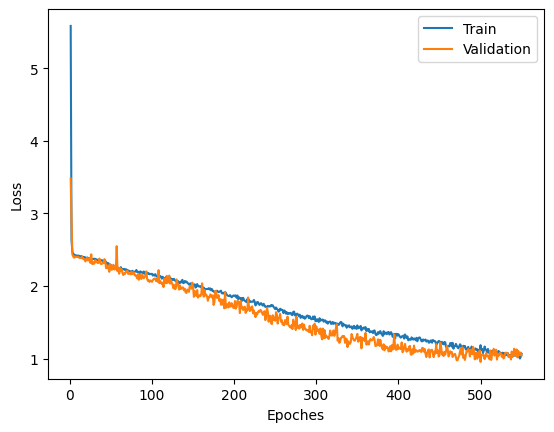

In [13]:
plot_loss(history)


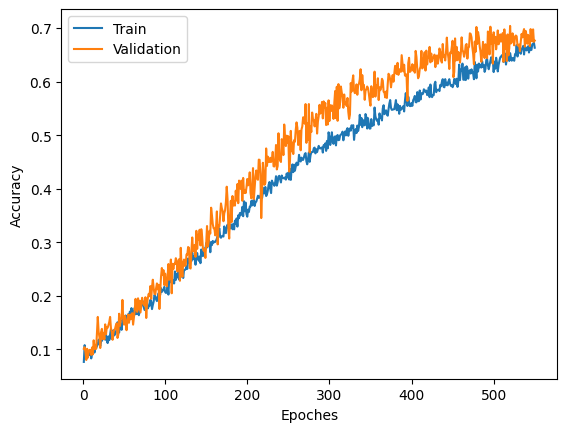

In [14]:
plot_acc(history)


## Testing


In [15]:
# model_path = "model/modelName/savedName.pth"
# bestd_model.load_state_dict(torch.load(model_path, map_location=device))


In [16]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestd_model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestd_model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
